<a href="https://colab.research.google.com/github/Yuto-Kishi/ECHONET-Lite/blob/main/est0123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# ============================================================
# Room-Specific Analysis (Split Files) - All Sensors + Appliances
# Weighted RF with Custom Threshold
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20
SEED = 42

# データの分割設定
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# 閾値設定 (見逃し防止)
THRESHOLD_OCCUPIED = 0.27

# 除外するラベル列
LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People" # Just in case
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")

    print("⚠️ タイムスタンプ補正を実行中...")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')

    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')

    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    fixed_dates = temp_dates + pd.to_timedelta(hours_to_add, unit='h')
    return fixed_dates

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def plot_cm_and_importance(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    if importances is not None:
        imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        top = imp.head(topk)[::-1]
        ax2.barh(top.index, top.values, color="skyblue")
        ax2.set_title(f"Feature Importance (Top {topk})")
        ax2.set_xlabel("Importance")

    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)
    if denom == 0: return pd.Series(0.0, index=y.index)
    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom
    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff"] = d1
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Model & Prediction
# =========================
def rf_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def predict_with_threshold(model, X, threshold=0.3):
    """確率閾値による判定"""
    probs = model.predict_proba(X)
    preds = np.argmax(probs, axis=1)

    for i in range(len(preds)):
        p0, p1, p2 = probs[i]
        # 0(不在)と判定されても、1or2の確率が閾値を超えていれば書き換え
        if preds[i] == 0:
            if p1 >= threshold or p2 >= threshold:
                preds[i] = 1 if p1 >= p2 else 2
    return preds

def run_room_file_analysis(filename: str, room: str, target_col: str):
    print(f"\n📥 Loading {room} data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns:
        raise ValueError(f"CSVに {TIME_COL} 列がありません。")
    if target_col not in df0.columns:
        raise ValueError(f"ラベル列 {target_col} がありません。")

    # Timestamp & Resample
    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    print("Resampling to 1min...")
    df = resample_1min(df0, RESAMPLE_RULE)

    # ラベル
    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # 特徴量選択 (全カラムからラベル以外を取得、種別判定)
    all_cols = [c for c in df.columns if c not in LABEL_COLS]

    # Human/PIR vs Numeric separation
    hum_cols = [c for c in all_cols if c.lower().endswith("_human") or "PIR" in c]
    num_cols = [c for c in all_cols if c not in hum_cols]

    # 特徴量作成
    print("Building features...")
    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print("\n" + "=" * 80)
    print(f"  [{room}] Analysis (Split Files)")
    print(f"  Features: {X.shape[1]}")
    print(f"  Train: {len(X_tr)}, Test: {len(X_te)}")
    print(f"  Test Label Dist: {y_te.value_counts().to_dict()}")
    print("=" * 80)

    # Train
    model = rf_model()
    model.fit(X_tr, y_tr)

    # Predict
    pred = predict_with_threshold(model, X_te, threshold=THRESHOLD_OCCUPIED)

    print(f"\n--- Result: {room} (Threshold={THRESHOLD_OCCUPIED}) ---")
    print(classification_report(y_te, pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        f"{room} RF Result (Th={THRESHOLD_OCCUPIED})",
        y_te, pred, [0, 1, 2],
        X.columns, model.feature_importances_
    )

# =========================
# Main Execution
# =========================
# Run for Living
run_room_file_analysis("リビング.csv", "Living", "Label_Living_Count")

# Run for Japanese
run_room_file_analysis("和室.csv", "Japanese", "Label_Japanese_Count")

print("\n✅ Done.")


📥 Loading Living data from: リビング.csv ...
Resampling to 1min...
Building features...


KeyboardInterrupt: 

In [ ]:
# ============================================================
# Room-Specific Analysis (Threshold = 0.30)
# Output Feature Importance List
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20
SEED = 42

BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# ★★★ 閾値を0.30に設定 ★★★
THRESHOLD = 0.34

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def plot_cm_and_importance(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title}\nAccuracy={acc:.4f} (Thresh={THRESHOLD})")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # Importance Plot
    ax2 = plt.subplot(1, 2, 2)
    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = imp.head(topk)[::-1]
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top {topk})")
    ax2.set_xlabel("Importance")

    plt.tight_layout()
    plt.show()

def print_top_features(feature_names, importances, topk=20):
    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print(f"\n--- Top {topk} Feature Importances ---")
    print(imp.head(topk))

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)
    if denom == 0: return pd.Series(0.0, index=y.index)
    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom
    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff"] = d1
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic
# =========================
def rf_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def run_room_file_analysis(filename: str, room: str, target_col: str):
    print(f"\n📥 Loading {room} data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns:
        print(f"Error: CSVに {TIME_COL} 列がありません。")
        return
    if target_col not in df0.columns:
        print(f"Error: ラベル列 {target_col} がありません。")
        return

    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    print("Resampling to 1min...")
    df = resample_1min(df0, RESAMPLE_RULE)

    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # All non-label columns as features
    all_cols = [c for c in df.columns if c not in LABEL_COLS]
    hum_cols = [c for c in all_cols if c.lower().endswith("_human") or "PIR" in c]
    num_cols = [c for c in all_cols if c not in hum_cols]

    print("Building features...")
    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print("\n" + "=" * 80)
    print(f"  [{room}] Analysis (Standard Prediction with Threshold {THRESHOLD})")
    print(f"  Features: {X.shape[1]}")
    print(f"  Test Label Dist: {y_te.value_counts().to_dict()}")
    print("=" * 80)

    model = rf_model()
    model.fit(X_tr, y_tr)

    # --- 閾値適用ロジック ---
    print(f"Applying threshold {THRESHOLD} to predictions...")
    probs = model.predict_proba(X_te)
    classes = model.classes_

    final_pred = []
    for p in probs:
        c_probs = {c: val for c, val in zip(classes, p)}

        # 0以外のクラス（1, 2）の中で、確率がTHRESHOLD以上のものを抽出
        candidates = {c: val for c, val in c_probs.items() if c != 0 and val >= THRESHOLD}

        if candidates:
            # 候補があれば、その中で最も確率が高いクラスを採用
            best_c = max(candidates, key=candidates.get)
            final_pred.append(best_c)
        else:
            # 閾値を超える「存在」クラスがなければ 0 (不在) と判定
            final_pred.append(0)

    final_pred = np.array(final_pred)
    # ---------------------------

    print(f"\n--- Result: {room} (Threshold {THRESHOLD}) ---")
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # Plot and Print Importance
    plot_cm_and_importance(
        f"{room} RF Result (Thresh={THRESHOLD})",
        y_te, final_pred, [0, 1, 2],
        X.columns, model.feature_importances_
    )
    print_top_features(X.columns, model.feature_importances_, TOPK_IMPORTANCE)

# =========================
# Main
# =========================
if __name__ == "__main__":
    run_room_file_analysis("/content/リビング_家電のみ.csv", "Living", "Label_Living_Count")
    run_room_file_analysis("/content/和室_家電のみ.csv", "Japanese", "Label_Japanese_Count")


📥 Loading Living data from: /content/リビング_家電のみ.csv ...
Resampling to 1min...
Building features...

  [Living] Analysis (Standard Prediction with Threshold 0.25)
  Features: 506
  Test Label Dist: {0: 6901, 2: 333, 1: 326}
Applying threshold 0.25 to predictions...

--- Result: Living (Threshold 0.25) ---
              precision    recall  f1-score   support

           0      0.997     0.981     0.989      6901
           1      0.814     0.887     0.849       326
           2      0.663     0.829     0.737       333

    accuracy                          0.971      7560
   macro avg      0.825     0.899     0.858      7560
weighted avg      0.975     0.971     0.972      7560



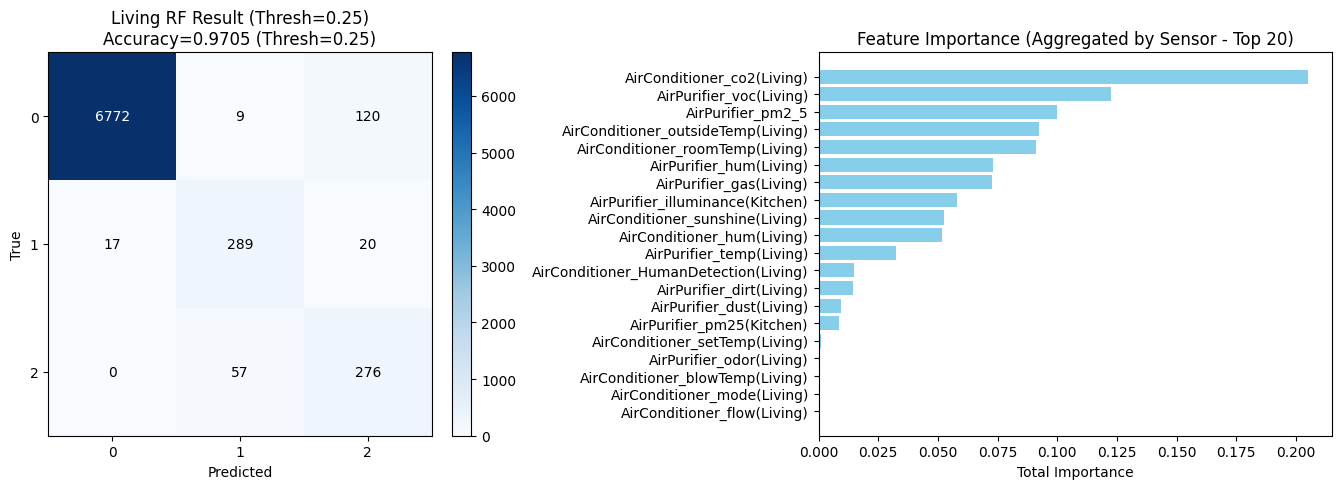


--- Top 20 Feature Importances (Aggregated by Sensor) ---
feature
AirConditioner_co2(Living)               0.204960
AirPurifier_voc(Living)                  0.122388
AirPurifier_pm2_5                        0.099901
AirConditioner_outsideTemp(Living)       0.092490
AirConditioner_roomTemp(Living)          0.091259
AirPurifier_hum(Living)                  0.072880
AirPurifier_gas(Living)                  0.072715
AirPurifier_illuminance(Kitchen)         0.058052
AirConditioner_sunshine(Living)          0.052587
AirConditioner_hum(Living)               0.051841
AirPurifier_temp(Living)                 0.032619
AirConditioner_HumanDetection(Living)    0.015014
AirPurifier_dirt(Living)                 0.014271
AirPurifier_dust(Living)                 0.009470
AirPurifier_pm25(Kitchen)                0.008575
AirConditioner_setTemp(Living)           0.000837
AirPurifier_odor(Living)                 0.000139
AirConditioner_blowTemp(Living)          0.000000
AirConditioner_mode(Living)      

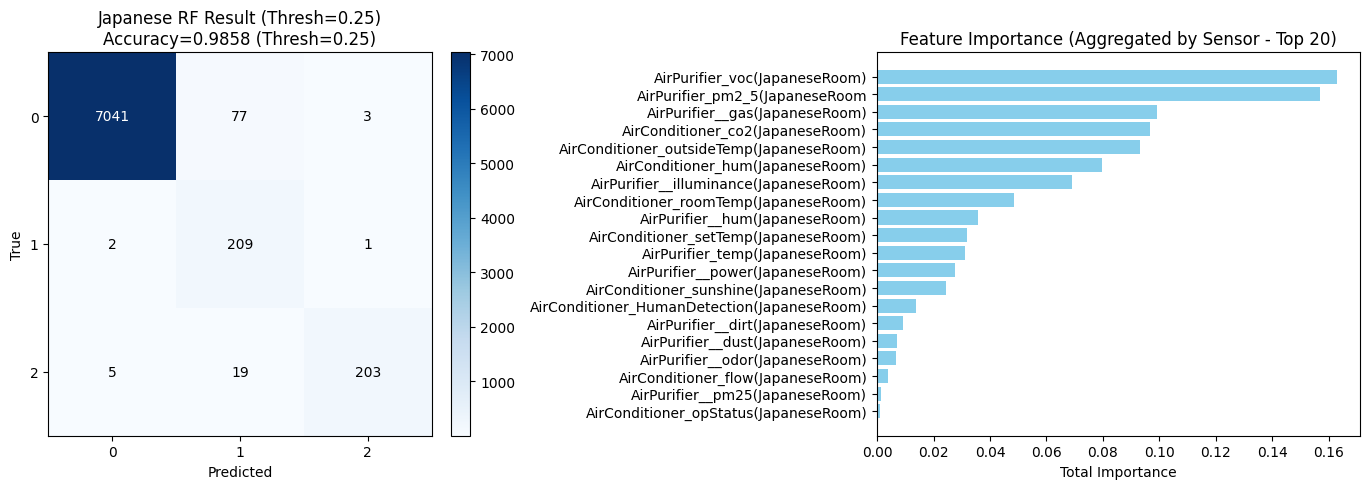


--- Top 20 Feature Importances (Aggregated by Sensor) ---
feature
AirPurifier_voc(JapaneseRoom)                  0.162966
AirPurifier_pm2_5(JapaneseRoom                 0.157035
AirPurifier__gas(JapaneseRoom)                 0.099267
AirConditioner_co2(JapaneseRoom)               0.096756
AirConditioner_outsideTemp(JapaneseRoom)       0.093290
AirConditioner_hum(JapaneseRoom)               0.079527
AirPurifier__illuminance(JapaneseRoom)         0.068925
AirConditioner_roomTemp(JapaneseRoom)          0.048351
AirPurifier__hum(JapaneseRoom)                 0.035874
AirConditioner_setTemp(JapaneseRoom)           0.031757
AirPurifier_temp(JapaneseRoom)                 0.031248
AirPurifier__power(JapaneseRoom)               0.027576
AirConditioner_sunshine(JapaneseRoom)          0.024516
AirConditioner_HumanDetection(JapaneseRoom)    0.013655
AirPurifier__dirt(JapaneseRoom)                0.009319
AirPurifier__dust(JapaneseRoom)                0.007100
AirPurifier__odor(JapaneseRoom)      

In [20]:
# ============================================================
# Room-Specific Analysis (Threshold = 0.30)
# Output Aggregated Feature Importance by Sensor Name
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20
SEED = 42

BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# 閾値設定 (前回同様0.30としています)
THRESHOLD = 0.25

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

# ---------------------------------------------------------
# Feature Importance Aggregation Logic
# ---------------------------------------------------------
def aggregate_importances(feature_names, importances):
    """
    特徴量名からサフィックス(_diff, _mean_XX, _std_XX, _slope_XX, _sum_XX)を取り除き、
    ベースとなるセンサー名ごとに重要度を合計する。
    """
    base_names = []
    # 正規表現で末尾の派生パターンを削除
    # 例: "AirConditioner_power_std_15" -> "AirConditioner_power"
    pattern = re.compile(r'(_diff|_mean_\d+|_std_\d+|_slope_\d+|_sum_\d+)$')

    for name in feature_names:
        base = pattern.sub('', name)
        base_names.append(base)

    df_imp = pd.DataFrame({
        'feature': base_names,
        'importance': importances
    })

    # ベース名でグループ化して合計
    grouped = df_imp.groupby('feature')['importance'].sum().sort_values(ascending=False)
    return grouped

def plot_cm_and_importance_aggregated(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    """
    重要度を集約してプロットするバージョン
    """
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Aggregation
    agg_imp = aggregate_importances(feature_names, importances)

    fig = plt.figure(figsize=(14, 5))

    # Confusion Matrix
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title}\nAccuracy={acc:.4f} (Thresh={THRESHOLD})")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    # Aggregated Importance Plot
    ax2 = plt.subplot(1, 2, 2)
    top = agg_imp.head(topk)[::-1] # Top K extraction for plotting
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Aggregated by Sensor - Top {topk})")
    ax2.set_xlabel("Total Importance")

    plt.tight_layout()
    plt.show()

def print_top_features_aggregated(feature_names, importances, topk=20):
    agg_imp = aggregate_importances(feature_names, importances)
    print(f"\n--- Top {topk} Feature Importances (Aggregated by Sensor) ---")
    print(agg_imp.head(topk))

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)
    if denom == 0: return pd.Series(0.0, index=y.index)
    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom
    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff"] = d1
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic
# =========================
def rf_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def run_room_file_analysis(filename: str, room: str, target_col: str):
    print(f"\n📥 Loading {room} data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns:
        print(f"Error: CSVに {TIME_COL} 列がありません。")
        return
    if target_col not in df0.columns:
        print(f"Error: ラベル列 {target_col} がありません。")
        return

    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    print("Resampling to 1min...")
    df = resample_1min(df0, RESAMPLE_RULE)

    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # All non-label columns as features
    all_cols = [c for c in df.columns if c not in LABEL_COLS]
    hum_cols = [c for c in all_cols if c.lower().endswith("_human") or "PIR" in c]
    num_cols = [c for c in all_cols if c not in hum_cols]

    print("Building features...")
    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print("\n" + "=" * 80)
    print(f"  [{room}] Analysis (Standard Prediction with Threshold {THRESHOLD})")
    print(f"  Features: {X.shape[1]}")
    print(f"  Test Label Dist: {y_te.value_counts().to_dict()}")
    print("=" * 80)

    model = rf_model()
    model.fit(X_tr, y_tr)

    # --- 閾値適用ロジック ---
    print(f"Applying threshold {THRESHOLD} to predictions...")
    probs = model.predict_proba(X_te)
    classes = model.classes_

    final_pred = []
    for p in probs:
        c_probs = {c: val for c, val in zip(classes, p)}

        # 0以外のクラス（1, 2）の中で、確率がTHRESHOLD以上のものを抽出
        candidates = {c: val for c, val in c_probs.items() if c != 0 and val >= THRESHOLD}

        if candidates:
            # 候補があれば、その中で最も確率が高いクラスを採用
            best_c = max(candidates, key=candidates.get)
            final_pred.append(best_c)
        else:
            # 閾値を超える「存在」クラスがなければ 0 (不在) と判定
            final_pred.append(0)

    final_pred = np.array(final_pred)
    # ---------------------------

    print(f"\n--- Result: {room} (Threshold {THRESHOLD}) ---")
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # Plot and Print Aggregated Importance
    plot_cm_and_importance_aggregated(
        f"{room} RF Result (Thresh={THRESHOLD})",
        y_te, final_pred, [0, 1, 2],
        X.columns, model.feature_importances_
    )
    print_top_features_aggregated(X.columns, model.feature_importances_, TOPK_IMPORTANCE)

# =========================
# Main
# =========================
if __name__ == "__main__":
    # ファイル名が正しいことを確認して実行してください
    try:
        run_room_file_analysis("/content/リビング_家電のみ.csv", "Living", "Label_Living_Count")
        run_room_file_analysis("/content/和室_家電のみ.csv", "Japanese", "Label_Japanese_Count")
    except FileNotFoundError:
        print("\n⚠️ ファイルが見つかりません。ファイルパスを確認してください。")
    print("\n✅ Done.")


  [Living] Analysis Mode: ALL
Selected Numeric Features (66): ['M5Stack_co2(Living)', 'M5Stack_temp(Living)', 'M5Stack_hum(Living)'] ...
Selected Human Features (6): ['PIR_motion(Living_NorthEast)', 'PIR_motion(Living_NorthWest)', 'PIR_motion(Living_SouthEast)'] ...

--- Classification Report (Living - all) ---
              precision    recall  f1-score   support

           0      0.998     0.979     0.988      6901
           1      0.771     0.929     0.843       326
           2      0.681     0.814     0.741       333

    accuracy                          0.969      7560
   macro avg      0.817     0.907     0.857      7560
weighted avg      0.974     0.969     0.971      7560



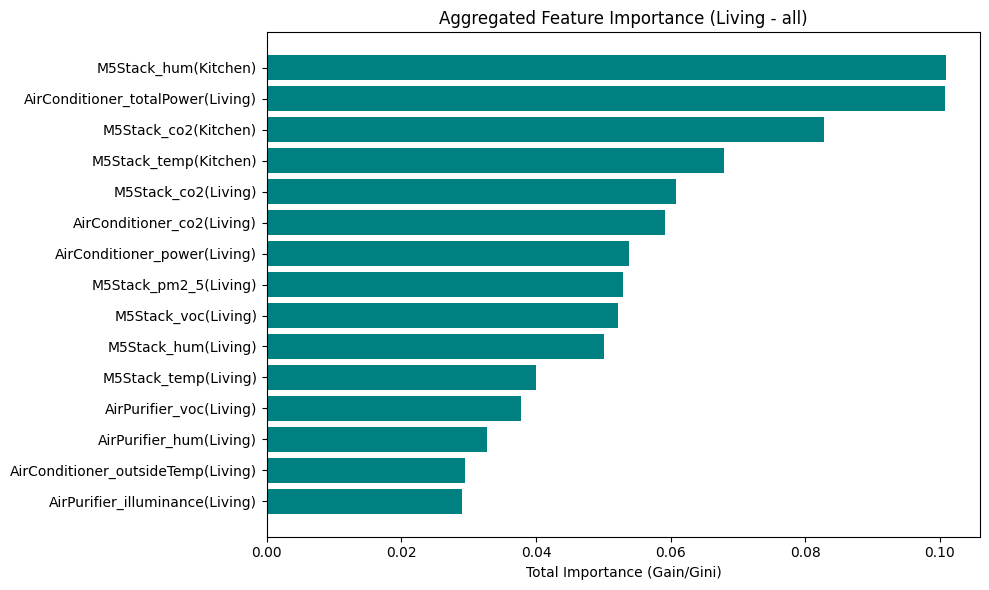


--- Top 15 Aggregated Features (Living - all) ---
feature
M5Stack_hum(Kitchen)                  0.100899
AirConditioner_totalPower(Living)     0.100719
M5Stack_co2(Kitchen)                  0.082767
M5Stack_temp(Kitchen)                 0.067859
M5Stack_co2(Living)                   0.060844
AirConditioner_co2(Living)            0.059199
AirConditioner_power(Living)          0.053762
M5Stack_pm2_5(Living)                 0.052946
M5Stack_voc(Living)                   0.052115
M5Stack_hum(Living)                   0.050155
M5Stack_temp(Living)                  0.040030
AirPurifier_voc(Living)               0.037829
AirPurifier_hum(Living)               0.032764
AirConditioner_outsideTemp(Living)    0.029366
AirPurifier_illuminance(Living)       0.029051
Name: importance, dtype: float64

  [Living] Analysis Mode: APPLIANCE_ONLY
Selected Numeric Features (23): ['AirPurifier_pm2_5', 'AirPurifier_voc(Living)', 'AirPurifier_opStatus(Living)'] ...
Selected Human Features (1): ['AirConditione

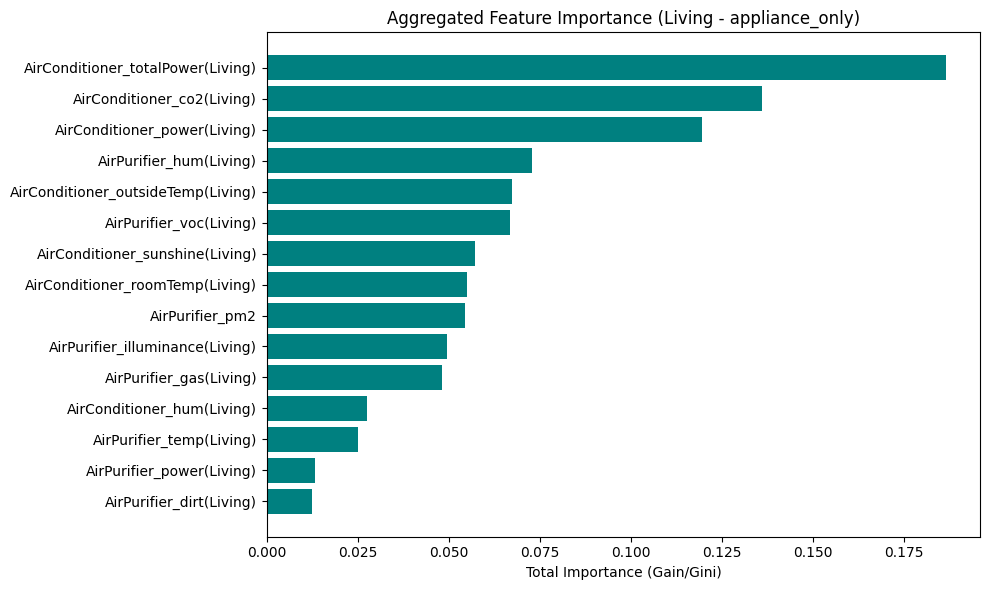


--- Top 15 Aggregated Features (Living - appliance_only) ---
feature
AirConditioner_totalPower(Living)     0.186575
AirConditioner_co2(Living)            0.136004
AirConditioner_power(Living)          0.119452
AirPurifier_hum(Living)               0.072844
AirConditioner_outsideTemp(Living)    0.067423
AirPurifier_voc(Living)               0.066884
AirConditioner_sunshine(Living)       0.057111
AirConditioner_roomTemp(Living)       0.055075
AirPurifier_pm2                       0.054466
AirPurifier_illuminance(Living)       0.049533
AirPurifier_gas(Living)               0.048097
AirConditioner_hum(Living)            0.027596
AirPurifier_temp(Living)              0.025052
AirPurifier_power(Living)             0.013347
AirPurifier_dirt(Living)              0.012319
Name: importance, dtype: float64

  [Japanese] Analysis Mode: ALL
Selected Numeric Features (28): ['M5Stack_co2(JapaneseRoom)', 'M5Stack_temp(JapaneseRoom)', 'M5Stack_hum(JapaneseRoom)'] ...
Selected Human Features (3): ['PIR

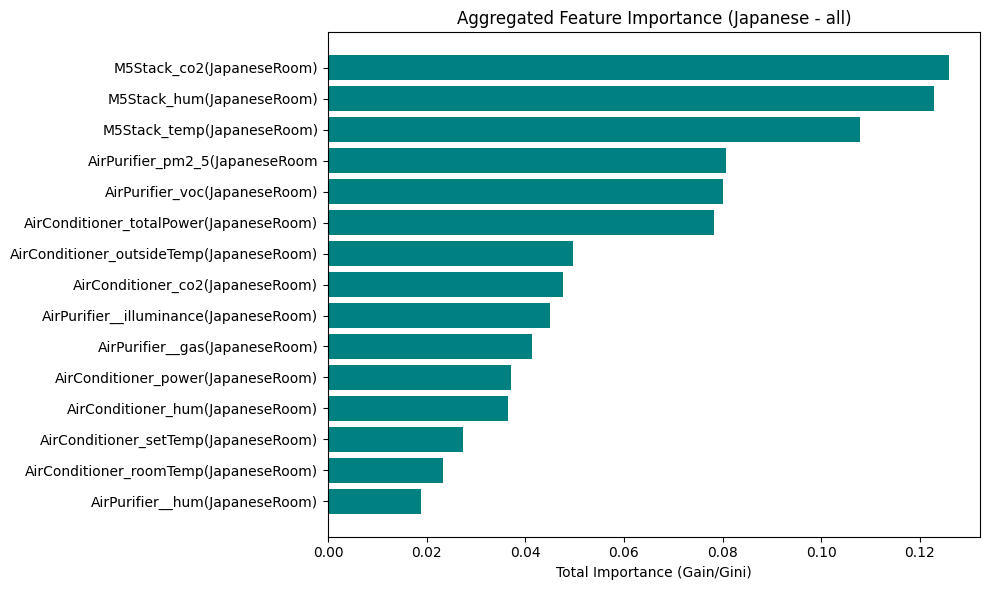


--- Top 15 Aggregated Features (Japanese - all) ---
feature
M5Stack_co2(JapaneseRoom)                   0.125881
M5Stack_hum(JapaneseRoom)                   0.122872
M5Stack_temp(JapaneseRoom)                  0.107860
AirPurifier_pm2_5(JapaneseRoom              0.080733
AirPurifier_voc(JapaneseRoom)               0.080010
AirConditioner_totalPower(JapaneseRoom)     0.078262
AirConditioner_outsideTemp(JapaneseRoom)    0.049612
AirConditioner_co2(JapaneseRoom)            0.047660
AirPurifier__illuminance(JapaneseRoom)      0.044995
AirPurifier__gas(JapaneseRoom)              0.041360
AirConditioner_power(JapaneseRoom)          0.037155
AirConditioner_hum(JapaneseRoom)            0.036461
AirConditioner_setTemp(JapaneseRoom)        0.027472
AirConditioner_roomTemp(JapaneseRoom)       0.023241
AirPurifier__hum(JapaneseRoom)              0.018898
Name: importance, dtype: float64

  [Japanese] Analysis Mode: APPLIANCE_ONLY
Selected Numeric Features (25): ['AirPurifier_pm2_5(JapaneseRoom', 

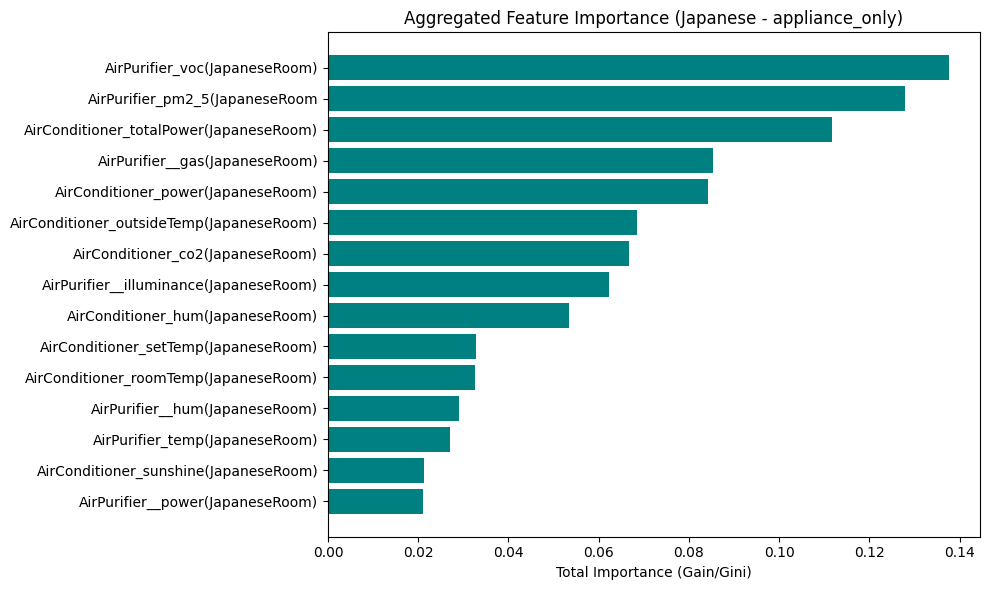


--- Top 15 Aggregated Features (Japanese - appliance_only) ---
feature
AirPurifier_voc(JapaneseRoom)               0.137610
AirPurifier_pm2_5(JapaneseRoom              0.127769
AirConditioner_totalPower(JapaneseRoom)     0.111608
AirPurifier__gas(JapaneseRoom)              0.085358
AirConditioner_power(JapaneseRoom)          0.084105
AirConditioner_outsideTemp(JapaneseRoom)    0.068443
AirConditioner_co2(JapaneseRoom)            0.066788
AirPurifier__illuminance(JapaneseRoom)      0.062292
AirConditioner_hum(JapaneseRoom)            0.053368
AirConditioner_setTemp(JapaneseRoom)        0.032823
AirConditioner_roomTemp(JapaneseRoom)       0.032501
AirPurifier__hum(JapaneseRoom)              0.029138
AirPurifier_temp(JapaneseRoom)              0.027073
AirConditioner_sunshine(JapaneseRoom)       0.021202
AirPurifier__power(JapaneseRoom)            0.021017
Name: importance, dtype: float64


In [9]:
# ============================================================
# Room-Specific Analysis (Aggregated Feature Importance)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 15  # 集約後のトップ表示数
SEED = 42

BLOCK_MINUTES = 30
TEST_RATIO = 0.30
THRESHOLD_OCCUPIED = 0.25

# 除外するラベル列
LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')
    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')
    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    return temp_dates + pd.to_timedelta(hours_to_add, unit='h')

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

# =========================
# Feature Importance Aggregation
# =========================
def plot_aggregated_importance(feature_names, importances, topk=15, title_suffix=""):
    # 特徴量名からベース名（センサー名）を抽出するロジック
    # 例: "M5Stack_co2_std_5" -> "M5Stack_co2"
    # 例: "AirConditioner_power_diff" -> "AirConditioner_power"

    base_features = []
    scores = []

    for name, score in zip(feature_names, importances):
        # 既知のサフィックスパターンを削除
        base_name = name
        # よくある統計サフィックスを削除 (_mean, _std, _slope, _diff など)
        base_name = re.sub(r'_(mean|std|slope|sum|diff|trend|monotonic|area|acceleration)(_\d+.*)?$', '', base_name)
        # 末尾の数字（ウィンドウサイズなど）も削除
        base_name = re.sub(r'_\d+$', '', base_name)

        base_features.append(base_name)
        scores.append(score)

    # 集計
    df_imp = pd.DataFrame({'feature': base_features, 'importance': scores})
    agg_imp = df_imp.groupby('feature')['importance'].sum().sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    top_plot = agg_imp.head(topk).iloc[::-1] # 上位K個を逆順（棒グラフ用）
    plt.barh(top_plot.index, top_plot.values, color="teal")
    plt.title(f"Aggregated Feature Importance {title_suffix}")
    plt.xlabel("Total Importance (Gain/Gini)")
    plt.tight_layout()
    plt.show()

    print(f"\n--- Top {topk} Aggregated Features {title_suffix} ---")
    print(agg_imp.head(topk))

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)
    if denom == 0: return pd.Series(0.0, index=y.index)
    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom
    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def build_features(df, num_cols, hum_cols, wins):
    # Numeric Features
    feats = {}
    for c in num_cols:
        s = pd.to_numeric(df[c], errors="coerce").fillna(0.0)
        feats[c] = s
        feats[f"{c}_diff"] = s.diff().fillna(0.0)
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = _rolling_linreg_slope(s, w)

    # Human/Binary Features
    for c in hum_cols:
        s = coerce_boolish_to_float(df[c]).fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)

    return pd.DataFrame(feats, index=df.index).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Main Logic
# =========================
def run_analysis(filename, room, target_col, mode="all"):
    """
    mode: "all" (Sensor + Appliance) or "appliance_only" (No M5/PIR)
    """
    print(f"\n{'='*80}")
    print(f"  [{room}] Analysis Mode: {mode.upper()}")
    print(f"{'='*80}")

    # Load
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df = resample_1min(safe_ffill(df0).fillna(0.0), RESAMPLE_RULE)

    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # --- Feature Selection Logic ---
    all_cols = [c for c in df.columns if c not in LABEL_COLS]

    if mode == "appliance_only":
        # 家電のみ: AirPurifier, AirConditioner を含むものだけ
        # M5StackやPIRは除外する
        selected_cols = [c for c in all_cols if ("AirPurifier" in c or "AirConditioner" in c)]
    else:
        # All: 全て使用
        selected_cols = all_cols

    # Human/Numeric 分離
    hum_cols = [c for c in selected_cols if c.lower().endswith("_human") or "HumanDetection" in c or "PIR" in c]
    num_cols = [c for c in selected_cols if c not in hum_cols]

    print(f"Selected Numeric Features ({len(num_cols)}): {num_cols[:3]} ...")
    print(f"Selected Human Features ({len(hum_cols)}): {hum_cols[:3]} ...")

    # Build
    X = build_features(df, num_cols, hum_cols, WINS)

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    # Train
    model = RandomForestClassifier(n_estimators=500, random_state=SEED, class_weight="balanced_subsample", min_samples_leaf=2, n_jobs=-1)
    model.fit(X_tr, y_tr)

    # Predict (Custom Threshold)
    probs = model.predict_proba(X_te)
    final_pred = []
    classes = model.classes_

    for p in probs:
        c_probs = {c: val for c, val in zip(classes, p)}
        candidates = {c: val for c, val in c_probs.items() if c != 0 and val >= THRESHOLD_OCCUPIED}
        if candidates:
            final_pred.append(max(candidates, key=candidates.get))
        else:
            final_pred.append(0)

    # Result
    print(f"\n--- Classification Report ({room} - {mode}) ---")
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # Aggregated Importance
    plot_aggregated_importance(X.columns, model.feature_importances_, topk=TOPK_IMPORTANCE, title_suffix=f"({room} - {mode})")

# =========================
# Execution
# =========================
if __name__ == "__main__":
    # Living Analysis
    run_analysis("/content/リビング.csv", "Living", "Label_Living_Count", mode="all")
    run_analysis("/content/リビング.csv", "Living", "Label_Living_Count", mode="appliance_only")

    # Japanese Analysis
    run_analysis("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="all")
    run_analysis("/content/和室.csv", "Japanese", "Label_Japanese_Count", mode="appliance_only")


📥 Loading Living data from: リビング.csv ...
Resampling to 1min...
Using Appliance Columns: 24 (Num: 23, Hum: 1)
  [Living] Train: 17591, Test: 7560

--- Result: Living (Appliance Only) ---
              precision    recall  f1-score   support

           0      0.997     0.980     0.989      6901
           1      0.789     0.908     0.845       326
           2      0.690     0.835     0.755       333

    accuracy                          0.971      7560
   macro avg      0.825     0.908     0.863      7560
weighted avg      0.975     0.971     0.972      7560



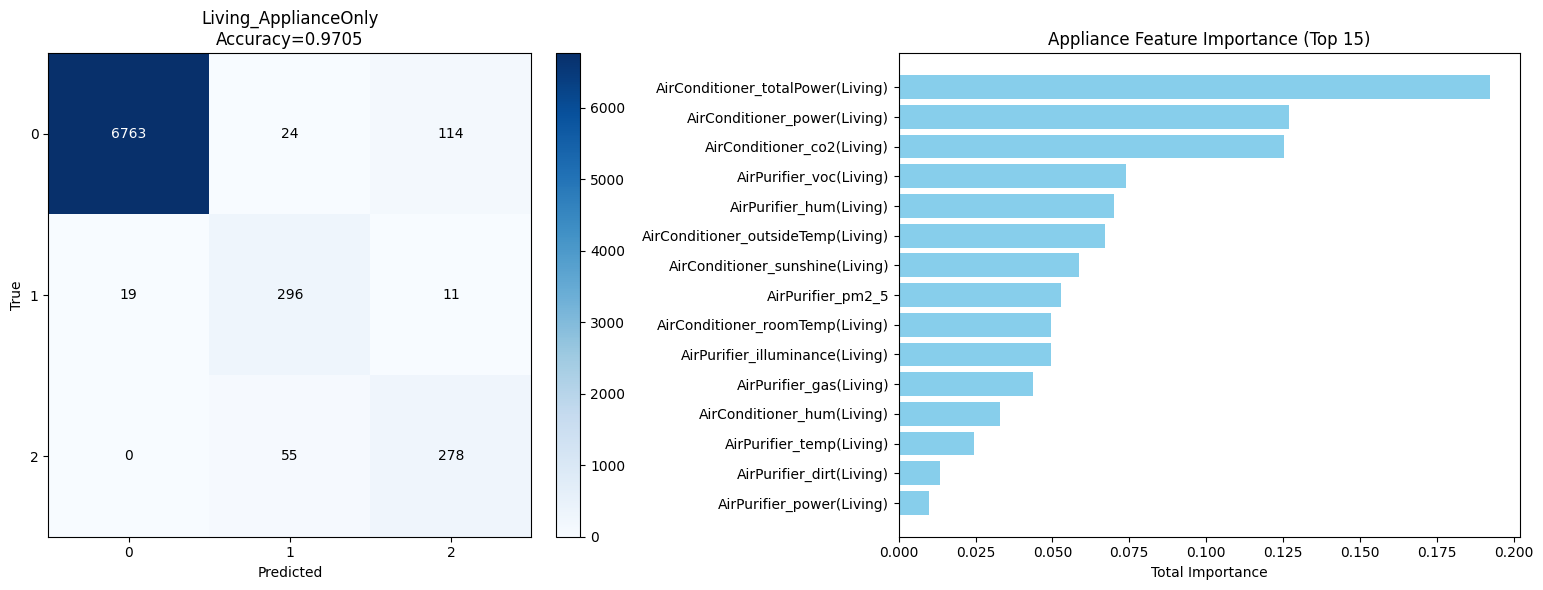


📥 Loading Japanese data from: 和室.csv ...
Resampling to 1min...
Using Appliance Columns: 26 (Num: 25, Hum: 1)
  [Japanese] Train: 17527, Test: 7560

--- Result: Japanese (Appliance Only) ---
              precision    recall  f1-score   support

           0      0.999     0.984     0.991      7121
           1      0.610     0.991     0.755       212
           2      0.990     0.894     0.940       227

    accuracy                          0.981      7560
   macro avg      0.867     0.956     0.895      7560
weighted avg      0.988     0.981     0.983      7560



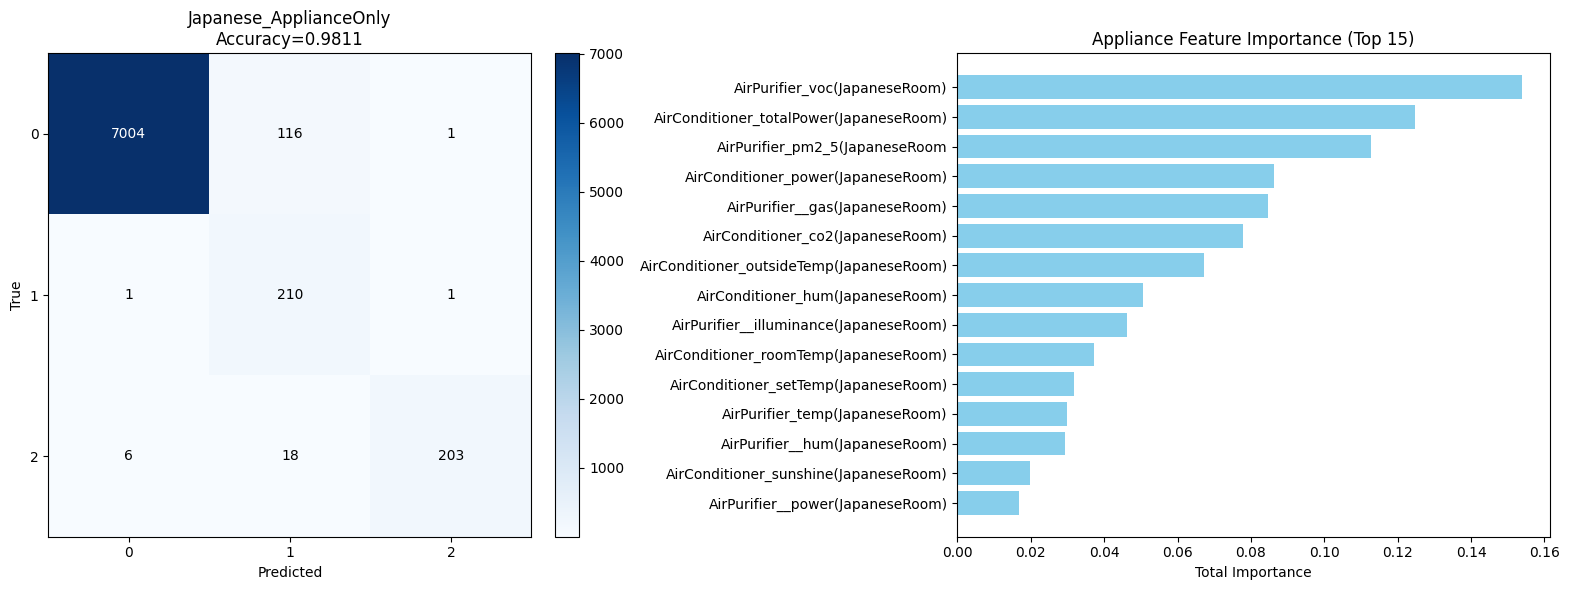


✅ Done.


In [12]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 15
SEED = 42

BLOCK_MINUTES = 30
TEST_RATIO = 0.30
THRESHOLD_OCCUPIED = 0.30

LABEL_COLS = [
    "Label_Living_Action",
    "Label_Living_Count",
    "Label_Japanese_Count",
    "Label_Japanese_Action",
    "Label_Total_People"
]

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")

    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')

    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')

    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    fixed_dates = temp_dates + pd.to_timedelta(hours_to_add, unit='h')
    return fixed_dates

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    if not out: return pd.DataFrame()
    dfr = pd.concat(out, axis=1).sort_index()
    return safe_ffill(dfr).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def aggregate_importances(feature_names, importances):
    base_feats = {}
    pattern = r'(_(mean|std|slope|sum)_\d+|_diff)$'
    for name, imp in zip(feature_names, importances):
        base_name = re.sub(pattern, '', name)
        if base_name in base_feats:
            base_feats[base_name] += imp
        else:
            base_feats[base_name] = imp
    return pd.Series(base_feats).sort_values(ascending=False)

def plot_cm_and_importance(title, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig = plt.figure(figsize=(16, 6))

    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color=text_color)

    ax2 = plt.subplot(1, 2, 2)
    if importances is not None:
        agg_imp = aggregate_importances(feature_names, importances)
        top = agg_imp.head(topk)[::-1]
        ax2.barh(top.index, top.values, color="skyblue")
        ax2.set_title(f"Appliance Feature Importance (Top {topk})")
        ax2.set_xlabel("Total Importance")

    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff"] = d1
        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w).std().fillna(0.0)
            # 傾き (簡易的に (Current - Old)/Window とする)
            feats[f"{c}_slope_{w}"] = (s - s.shift(w)).fillna(0.0) / w
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X.loc[:, ~X.columns.duplicated()]

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}"] = s.rolling(w).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# =========================
# Model & Prediction
# =========================
def rf_model():
    return RandomForestClassifier(
        n_estimators=300,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=4,
        max_depth=20
    )

def predict_with_threshold(model, X, threshold=0.3):
    probs = model.predict_proba(X)
    preds = np.argmax(probs, axis=1)
    for i in range(len(preds)):
        if preds[i] == 0:
            p_1 = probs[i][1] if probs.shape[1] > 1 else 0
            p_2 = probs[i][2] if probs.shape[1] > 2 else 0
            if p_1 >= threshold or p_2 >= threshold:
                preds[i] = 1 if p_1 >= p_2 else 2
    return preds

def run_appliance_only_analysis(filename: str, room: str, target_col: str):
    print(f"\n📥 Loading {room} data from: {filename} ...")
    try:
        df0 = pd.read_csv(filename, low_memory=False)
    except UnicodeDecodeError:
        df0 = pd.read_csv(filename, low_memory=False, encoding='cp932')

    if TIME_COL not in df0.columns:
        print(f"Error: {TIME_COL} not found.")
        return

    df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
    df0 = safe_ffill(df0).fillna(0.0)

    print("Resampling to 1min...")
    df = resample_1min(df0, RESAMPLE_RULE)

    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)
    y = y.apply(lambda x: x if x in [0, 1, 2] else 0)

    # === 家電のみのフィルタリング ===
    # キーワード: "AirPurifier" または "AirConditioner" を含む列のみ使用
    # 他のセンサー(M5Stack, PIRなど)は除外されます
    all_cols = [c for c in df.columns if c not in LABEL_COLS]
    appliance_cols = [c for c in all_cols if "AirPurifier" in c or "AirConditioner" in c]

    # センサーの種類別にリスト作成
    hum_cols = [c for c in appliance_cols if "human" in c.lower()] # 家電内蔵の人感センサーなど
    num_cols = [c for c in appliance_cols if c not in hum_cols]

    print(f"Using Appliance Columns: {len(appliance_cols)} (Num: {len(num_cols)}, Hum: {len(hum_cols)})")

    # 特徴量作成
    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1).fillna(0.0)

    # Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_te, y_te = X.iloc[te_idx], y.iloc[te_idx]

    print(f"  [{room}] Train: {len(X_tr)}, Test: {len(X_te)}")

    model = rf_model()
    model.fit(X_tr, y_tr)

    pred = predict_with_threshold(model, X_te, threshold=THRESHOLD_OCCUPIED)

    print(f"\n--- Result: {room} (Appliance Only) ---")
    print(classification_report(y_te, pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        f"{room}_ApplianceOnly",
        y_te, pred, [0, 1, 2],
        X.columns, model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Main Execution
# =========================
run_appliance_only_analysis("リビング.csv", "Living", "Label_Living_Count")
run_appliance_only_analysis("和室.csv", "Japanese", "Label_Japanese_Count")
print("\n✅ Done.")